In [32]:
import os
import scipy

import keras
import matplotlib.image as mpimg
import matplotlib.patches as matplotlib_patches
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from keras.layers import Input
from keras.layers.core import Activation, Reshape, Dropout
from keras.layers.convolutional import Conv2D, MaxPooling2D, UpSampling2D
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator

from functions_v1 import *

% matplotlib inline
% load_ext autoreload
% autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
n = 100  # number of image to load

# Loaded a set of images
root_dir = "datas/training/"

image_dir = root_dir + "images/"
files = os.listdir(image_dir)
files.sort()
n = min(n, len(files))  # Load maximum 20 images
print("Loading " + str(n) + " images")
imgs = np.array([load_image(image_dir + files[i]) for i in range(n)])
print(files[0])

gt_dir = root_dir + "groundtruth/"
print("Loading " + str(n) + " groundtruth")
gt_imgs = np.array([load_image(gt_dir + files[i]) for i in range(n)])
print(files[0])

Loading 100 images
satImage_001.png
Loading 100 groundtruth
satImage_001.png


## Discretize Y

In [3]:
Y = gt_imgs.reshape(100*400*400)
for i in range(len(Y)):
    Y[i] = round(Y[i])
Y = Y.reshape(100, 400, 400)

## Autoencoder
### Model

In [67]:
def SegNet(input_shape=(400, 400, 3), classes=2):
    img_input = Input(shape=input_shape)
    x = img_input
    
    # Encoder
    x = Conv2D(64, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Conv2D(128, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Conv2D(256, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Conv2D(512, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    # Decoder
    x = Conv2D(512, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(256, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(128, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(64, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
#     x = Dropout(0.5)(x)
    
    x = Conv2D(classes, (1, 1), padding="valid")(x)
    x = Reshape((input_shape[0] * input_shape[1], classes))(x)
    x = Activation("softmax")(x)
    model = Model(img_input, x)
    return model

In [68]:
input_shape = (400, 400, 3)
classes = 2
epochs = 10
batch_size = 4

In [135]:
x_train, x_test, y_train, y_test = train_test_split(imgs, Y, test_size=0.01, random_state=42)

In [70]:
y_train_categorical = keras.utils.to_categorical(np.array(y_train).reshape(len(y_train), 160000), num_classes=2)
y_test_categorical = keras.utils.to_categorical(np.array(y_test).reshape(len(y_test), 160000), num_classes=2)

In [165]:
from sklearn.utils import class_weight

class_weight = class_weight.compute_class_weight('balanced', np.array([0, 1]), Y.reshape(len(Y)*400*400))
class_weight

array([ 0.62536613,  2.49415899])

### Training

In [192]:
datagen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True)
train_generator = datagen.flow(x_train, y_train_categorical, batch_size=batch_size)


In [166]:
model = SegNet(input_shape=input_shape, classes=classes)
model.compile(loss="categorical_crossentropy", optimizer='adadelta', metrics=["accuracy"])


In [202]:
# model.fit(x_train, y_train_categorical, batch_size=batch_size, epochs=epochs,
#           verbose=1, class_weight=class_weight , validation_data=(x_test, y_test_categorical), shuffle=True)


model.fit_generator(train_generator,
                    class_weight=class_weight,
                    epochs=epochs,
                    steps_per_epoch=25,
                    shuffle=True)


Epoch 1/10
25/25 [==============================] - 24s 956ms/step - loss: 0.4083 - acc: 0.8395
Epoch 2/10
25/25 [==============================] - 24s 947ms/step - loss: 0.4209 - acc: 0.8308
Epoch 3/10
25/25 [==============================] - 24s 947ms/step - loss: 0.4212 - acc: 0.8302
Epoch 4/10
25/25 [==============================] - 24s 948ms/step - loss: 0.4146 - acc: 0.8330
Epoch 5/10
25/25 [==============================] - 24s 948ms/step - loss: 0.3994 - acc: 0.8394
Epoch 6/10
25/25 [==============================] - 24s 948ms/step - loss: 0.4287 - acc: 0.8287
Epoch 7/10
25/25 [==============================] - 24s 948ms/step - loss: 0.4333 - acc: 0.8251
Epoch 8/10
25/25 [==============================] - 24s 949ms/step - loss: 0.4025 - acc: 0.8397
Epoch 9/10
25/25 [==============================] - 24s 948ms/step - loss: 0.3927 - acc: 0.8428
Epoch 10/10
25/25 [==============================] - 24s 950ms/step - loss: 0.4125 - acc: 0.8336


In [194]:
score = model.evaluate(x_test, y_test_categorical, batch_size)
score

1/1 [==============================] - 0s 129ms/step


[0.48293241858482361, 0.77831250429153442]

In [203]:
model.save_weights("./weights/segnet.h5")

In [204]:
predictions = model.predict(imgs[0:1])

In [205]:
predictions[0].shape

(160000, 2)

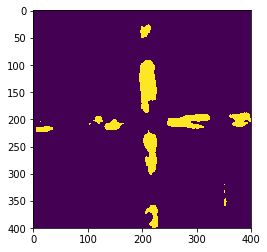

In [206]:
plt.imshow(np.argmax(predictions[0], axis=1).reshape(400,400))

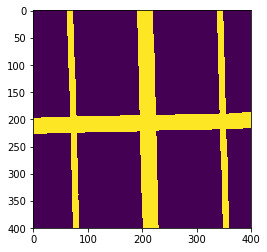

In [158]:
plt.imshow(Y[0])

## Test

In [210]:
test_dir = "datas/test_set_images/"
files = os.listdir(test_dir)
n = min(100, len(files))  # Load maximum 20 images
files.sort()
print("Loading " + str(n) + " images")
test_imgs = np.array([load_image(test_dir + files[i] + '/' + os.listdir(test_dir + files[i])[0]) for i in range(n)])
print("Loaded !")

Loading 50 images
Loaded !


/home/m.victor.le/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  """Entry point for launching an IPython kernel.


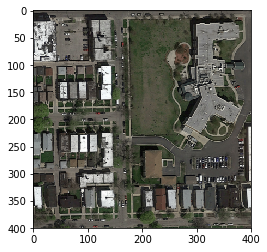

In [217]:
resized = scipy.misc.imresize(test_imgs[2], size=(400, 400))
plt.imshow(resized)

In [218]:
predictions = model.predict(np.array([resized]))

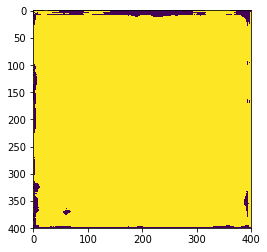

In [219]:
plt.imshow(np.argmax(predictions[0], axis=1).reshape(400,400))